# Tarea 4: Funciones, Modelos Personalizados y Ecuaciones Diferenciales

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.datasets import mnist, cifar10

import numpy as np
import matplotlib.pyplot as plt

import mlflow
import dagshub

plt.style.use('default')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

np.random.seed(42)
tf.random.set_seed(42)

In [4]:
gpus = tf.config.list_physical_devices('GPU')
print(f"GPUs disponibles: {len(gpus)}")

if gpus:
    for i, gpu in enumerate(gpus):
        print(f"GPU {i}: {gpu}")
    
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Crecimiento de memoria GPU configurado")
    except RuntimeError as e:
        print(f"Error al configurar GPU: {e}")
else:
    print("No se detectó GPU. El entrenamiento usará CPU.")

GPUs disponibles: 1
GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Crecimiento de memoria GPU configurado


In [5]:
dagshub.init(repo_owner='404brainnotfound-ai', repo_name='RNA', mlflow=True)
print(f"Tracking URI: {mlflow.get_tracking_uri()}")

Accessing as 404brainnotfound-ai

Initialized MLflow to track repo "404brainnotfound-ai/RNA"

Repository 404brainnotfound-ai/RNA initialized!

Tracking URI: https://dagshub.com/404brainnotfound-ai/RNA.mlflow


---
## Problema 1: Capa RGB a Escala de Grises

In [6]:
class CapaGrises(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(CapaGrises, self).__init__(**kwargs)
        self.rgb_weights = tf.constant([0.299, 0.587, 0.114], dtype=tf.float32)
    
    def call(self, inputs):
        r = inputs[:, :, :, 0]
        g = inputs[:, :, :, 1]
        b = inputs[:, :, :, 2]
        grises = 0.299 * r + 0.587 * g + 0.114 * b
        grises = tf.expand_dims(grises, axis=-1)
        return grises
    
    def get_config(self):
        config = super(CapaGrises, self).get_config()
        return config

In [7]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_test = x_test.astype(np.float32) / 255.0

print(f"Shape original: {x_test.shape}")
print(f"Rango: [{x_test.min():.2f}, {x_test.max():.2f}]")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step
Shape original: (10000, 32, 32, 3)
Rango: [0.00, 1.00]


In [8]:
with tf.device('/GPU:0' if gpus else '/CPU:0'):
    model_p1 = Sequential([
        Input(shape=(32, 32, 3)),
        CapaGrises(),])

model_p1.summary()

x_gray = model_p1.predict(x_test[:10], verbose=0)
print(f"Shape después: {x_gray.shape}")

I0000 00:00:1764034394.146374   23065 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2857 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ capa_grises (CapaGrises)        │ (None, 32, 32, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

2025-11-24 19:33:14.421179: I external/local_xla/xla/service/service.cc:163] XLA service 0x7557740024c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-24 19:33:14.421229: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1050 Ti, Compute Capability 6.1
2025-11-24 19:33:14.494998: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600


Shape después: (10, 32, 32, 1)


I0000 00:00:1764034394.942872   27120 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [12]:
test_img = x_test[0]
manual_gray = (0.299 * test_img[:,:,0] + 0.587 * test_img[:,:,1] + 0.114 * test_img[:,:,2])
layer_gray = x_gray[0, :, :, 0]
difference = np.abs(manual_gray - layer_gray).max()

print(f"Diferencia máxima: {difference:.10f}")
print("Correcto" if difference < 1e-6 else "Error")

Diferencia máxima: 0.0000000000
Correcto


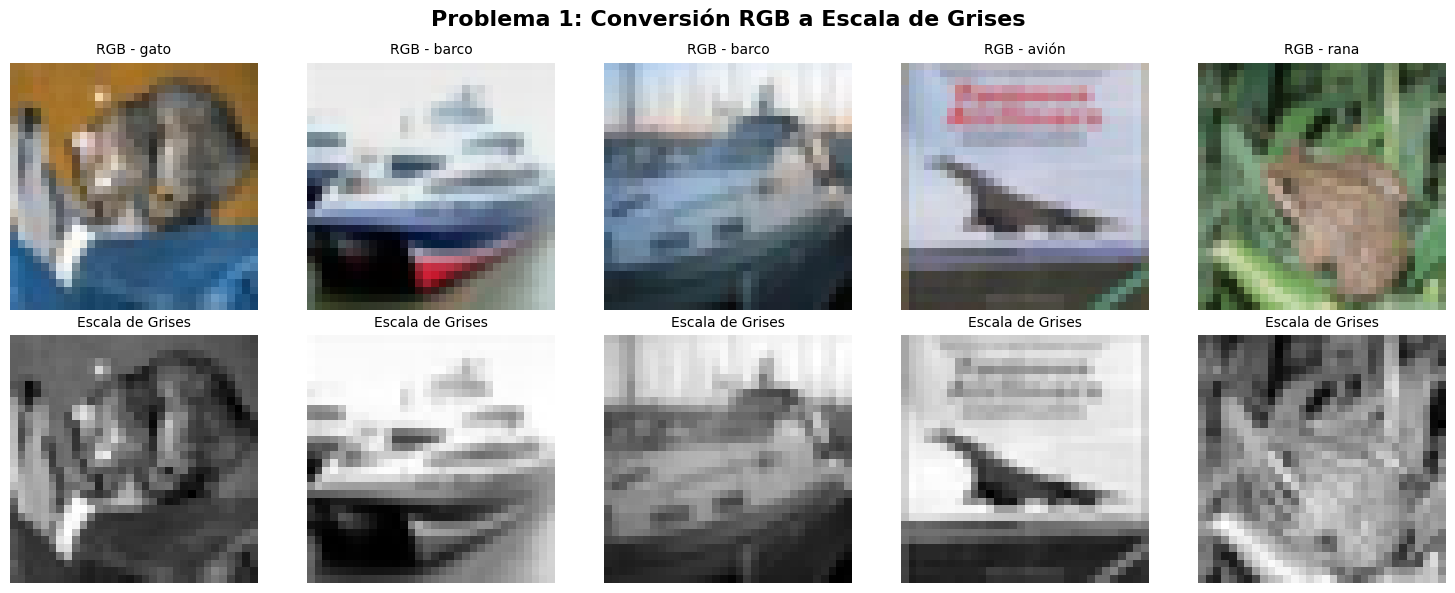

In [13]:
class_names = ['avión', 'auto', 'pájaro', 'gato', 'ciervo', 'perro', 'rana', 'caballo', 'barco', 'camión']

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Problema 1: Conversión RGB a Escala de Grises', fontsize=16, fontweight='bold')

for i in range(5):
    axes[0, i].imshow(x_test[i])
    axes[0, i].set_title(f'RGB - {class_names[y_test[i][0]]}', fontsize=10)
    axes[0, i].axis('off')
    
    axes[1, i].imshow(x_gray[i, :, :, 0], cmap='gray')
    axes[1, i].set_title('Escala de Grises', fontsize=10)
    axes[1, i].axis('off')

plt.tight_layout()
plt.savefig('problema1_resultado.png', dpi=300, bbox_inches='tight')
plt.show()

---
## Problema 2: Aproximación de Funciones

In [14]:
loss_tracker = keras.metrics.Mean(name="loss")

class FuncionAproximador(keras.Model):
    def __init__(self, funcion_objetivo, **kwargs):
        super(FuncionAproximador, self).__init__(**kwargs)
        self.funcion_objetivo = funcion_objetivo
    
    @property
    def metrics(self):
        return [loss_tracker]
    
    def train_step(self, data):
        batch_size = 300
        x = tf.random.uniform((batch_size,), minval=-1, maxval=1)
        y_true = self.funcion_objetivo(x)
        
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            mse_loss = keras.losses.MeanSquaredError()
            loss = mse_loss(y_true, y_pred)
        
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        loss_tracker.update_state(loss)
        
        return {"loss": loss_tracker.result()}

### Problema 2a: f(x) = 3sin(πx)

In [15]:
def funcion_2a(x):
    return 3 * tf.sin(np.pi * x)

inputs = keras.Input(shape=(1,))
x = Dense(150, activation='tanh')(inputs)
x = Dense(100, activation='tanh')(x)
x = Dense(1)(x)

with tf.device('/GPU:0' if gpus else '/CPU:0'):
    model_2a = FuncionAproximador(funcion_2a, inputs=inputs, outputs=x)

model_2a.summary()

Model: "funcion_aproximador"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 150)            │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,501 (60.55 KB)

 Trainable params: 15,501 (60.55 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
with mlflow.start_run(run_name="problema_2a_3sin_pix"):
    mlflow.log_param("problema", "2a")
    mlflow.log_param("funcion", "3*sin(pi*x)")
    mlflow.log_param("arquitectura", "[150, 100]")
    mlflow.log_param("activacion", "tanh")
    mlflow.log_param("gpu", "GTX 1050 Ti" if gpus else "CPU")
    
    model_2a.compile(optimizer=Adam(learning_rate=0.05), metrics=['loss'])
    
    x_train = tf.linspace(-1, 1, 100)
    history_2a = model_2a.fit(x_train, epochs=70, verbose=1)
    
    final_loss = history_2a.history['loss'][-1]
    mlflow.log_metric("final_loss", final_loss)
    mlflow.log_metric("epochs", len(history_2a.history['loss']))
    
    model_2a.save('model_2a.keras')
    mlflow.log_artifact('model_2a.keras', artifact_path="models")
    
    print(f"Loss final: {final_loss:.6f}")

Epoch 1/70


2025-11-24 19:41:10.470799: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-24 19:41:10.552599: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:62] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform/RandomUniform


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 249ms/step - loss: 9.8653
Epoch 2/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.0602
Epoch 3/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0018
Epoch 4/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0075
Epoch 5/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0078 
Epoch 6/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8295
Epoch 7/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5899
Epoch 8/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3786
Epoch 9/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2898 
Epoch 10/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2215
Epoch 11/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1419
Epoch 12/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1141 
Epoch 13/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0918 
Epoch 14/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0786
Epoch 15/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0583
Epoch 16/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms

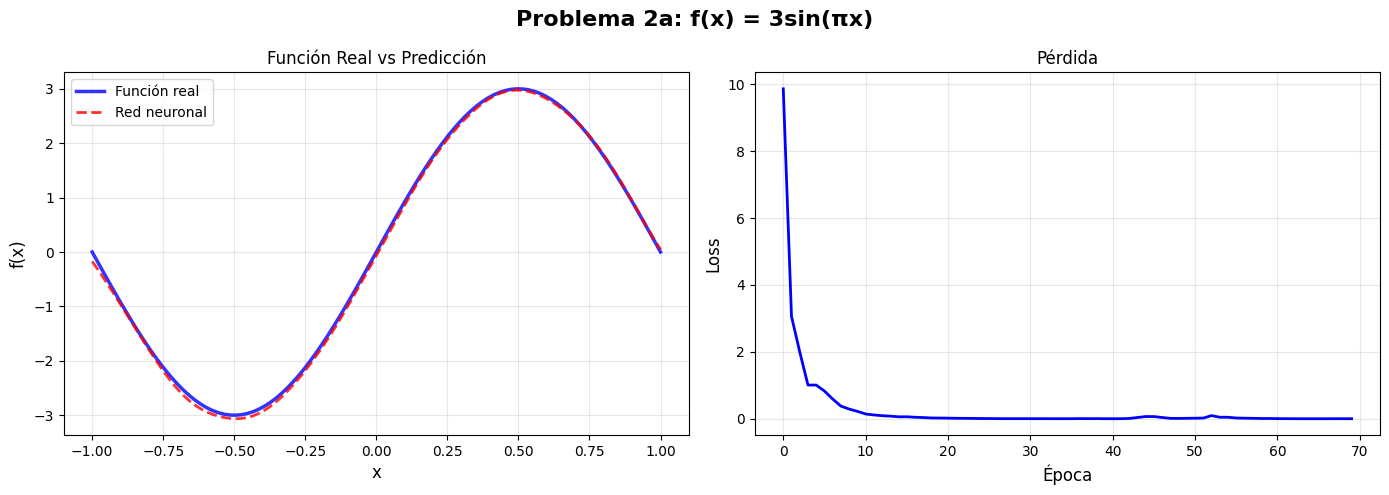

MSE: 0.003320
MAE: 0.050489
Error máximo: 0.173455


In [17]:
x_test = tf.linspace(-1, 1, 100)
y_true_2a = funcion_2a(x_test).numpy()
y_pred_2a = model_2a.predict(x_test, verbose=0)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Problema 2a: f(x) = 3sin(πx)', fontsize=16, fontweight='bold')

axes[0].plot(x_test, y_true_2a, 'b-', linewidth=2.5, label='Función real', alpha=0.8)
axes[0].plot(x_test, y_pred_2a, 'r--', linewidth=2, label='Red neuronal', alpha=0.8)
axes[0].set_xlabel('x', fontsize=12)
axes[0].set_ylabel('f(x)', fontsize=12)
axes[0].set_title('Función Real vs Predicción', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_2a.history['loss'], 'b-', linewidth=2)
axes[1].set_xlabel('Época', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Pérdida', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('problema2a_resultado.png', dpi=300, bbox_inches='tight')
plt.show()

error_2a = np.abs(y_true_2a - y_pred_2a.flatten())
print(f"MSE: {np.mean(error_2a**2):.6f}")
print(f"MAE: {np.mean(error_2a):.6f}")
print(f"Error máximo: {error_2a.max():.6f}")

### Problema 2b: f(x) = 1 + 2x + 4x³

In [18]:
def funcion_2b(x):
    return 1 + 2*x + 4*tf.pow(x, 3)

inputs = keras.Input(shape=(1,))
x = Dense(150, activation='tanh')(inputs)
x = Dense(100, activation='tanh')(x)
x = Dense(1)(x)

with tf.device('/GPU:0' if gpus else '/CPU:0'):
    model_2b = FuncionAproximador(funcion_2b, inputs=inputs, outputs=x)

Epoch 1/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 246ms/step - loss: 7.1489
Epoch 2/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.6002
Epoch 3/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.9477
Epoch 4/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4585
Epoch 5/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3993
Epoch 6/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1990
Epoch 7/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9340
Epoch 8/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6322
Epoch 9/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4094
Epoch 10/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2838
Epoch 11/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1830
Epoch 12/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0989
Epoch 13/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0786
Epoch 14/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0617
Epoch 15/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0532
Epoch 16/70
4/4 ━━━━━━━━━━━━━━━━━

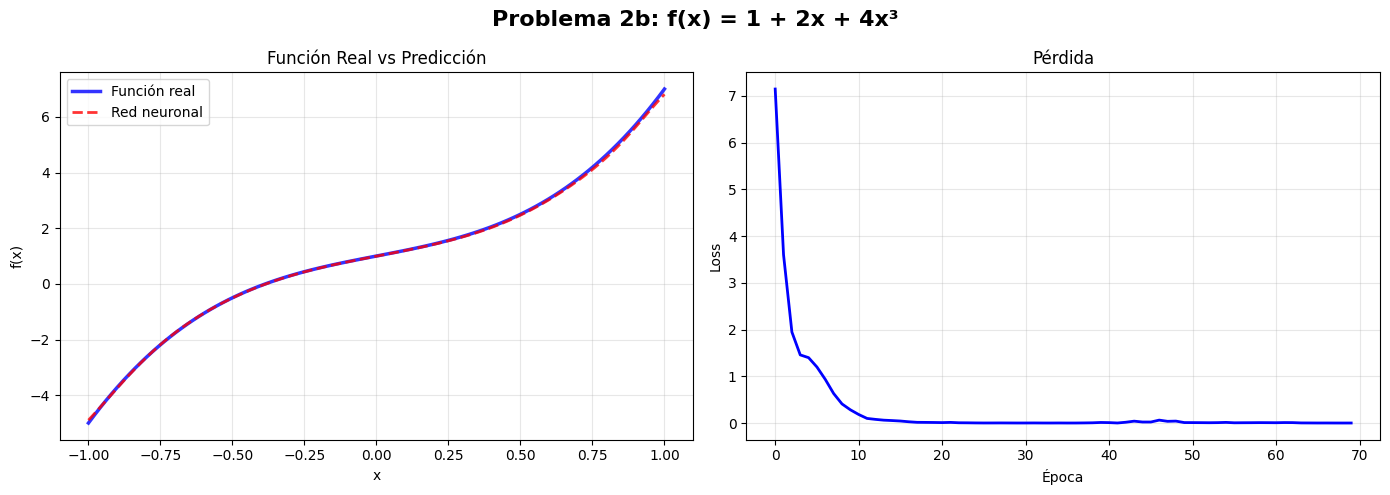

In [19]:
with mlflow.start_run(run_name="problema_2b_polinomio"):
    mlflow.log_param("problema", "2b")
    mlflow.log_param("funcion", "1 + 2x + 4x^3")
    mlflow.log_param("arquitectura", "[150, 100]")
    mlflow.log_param("gpu", "GTX 1050 Ti" if gpus else "CPU")
    
    model_2b.compile(optimizer=Adam(learning_rate=0.05), metrics=['loss'])
    history_2b = model_2b.fit(x_train, epochs=70, verbose=1)
    
    mlflow.log_metric("final_loss", history_2b.history['loss'][-1])
    model_2b.save('model_2b.keras')
    mlflow.log_artifact('model_2b.keras', artifact_path="models")

y_true_2b = funcion_2b(x_test).numpy()
y_pred_2b = model_2b.predict(x_test, verbose=0)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Problema 2b: f(x) = 1 + 2x + 4x³', fontsize=16, fontweight='bold')

axes[0].plot(x_test, y_true_2b, 'b-', linewidth=2.5, label='Función real', alpha=0.8)
axes[0].plot(x_test, y_pred_2b, 'r--', linewidth=2, label='Red neuronal', alpha=0.8)
axes[0].set_xlabel('x')
axes[0].set_ylabel('f(x)')
axes[0].set_title('Función Real vs Predicción')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_2b.history['loss'], 'b-', linewidth=2)
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Loss')
axes[1].set_title('Pérdida')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('problema2b_resultado.png', dpi=300, bbox_inches='tight')
plt.show()